# Genesis4 Benchmark on Perlmutter (NERSC)

HPC systems often have special commands to invoke MPI jobs. NERSC uses slurm, which provides `srun` in place of `mpirun`.

In [1]:
from genesis.version4 import Genesis4
import os

The `MPI_RUN` class attribute needs to be replaced. For convenience, Genesis4 tries to detect NERSC:

In [2]:
Genesis4.MPI_RUN

'srun -n {nproc} --ntasks-per-node {nproc} -c 1 {command_mpi}'

Additionally, the working directory must be on the scratch disk. This is automatically detected:

In [3]:
Genesis4.WORKDIR

'/pscratch/sd/c/cmayes'

Create Genesis4 object:

In [4]:
FILE = "data/basic4/cu_hxr.in"
G = Genesis4(FILE)

Set up the benchmark

In [5]:
G.input["main"][6]["zstop"] = 40

Run with MPI

In [6]:
%%time
G.verbose = False
G.nproc = 128
G.run()

CPU times: user 15.7 ms, sys: 79.2 ms, total: 94.9 ms
Wall time: 8.62 s


# Timing

In [7]:
MAX_CPUS = os.cpu_count()
CPUS_PER_NODE = 128
MIN_CPUS = MAX_CPUS // 8
MAX_CPUS, MIN_CPUS

(256, 32)

In [8]:
def time1(nproc):
    G.verbose = False
    G.nproc = nproc
    G.nnode = (nproc - 1) // CPUS_PER_NODE + 1
    G.run()
    dt = G.output["run_info"]["run_time"]
    return dt


time1(MAX_CPUS)

11.547049283981323

In [9]:
%%time
nlist = []
tlist = []
n_cpu = MAX_CPUS
while n_cpu > 0:
    n = n_cpu
    if n < MIN_CPUS:
        break
    nlist.append(n)
    dt = time1(n)
    tlist.append(dt)
    print(f"{n} cores, {dt:0.1f} s")
    n_cpu = n_cpu // 2

256 cores, 12.2 s
128 cores, 8.7 s
64 cores, 15.5 s
32 cores, 28.2 s
CPU times: user 137 ms, sys: 239 ms, total: 375 ms
Wall time: 1min 4s


In [10]:
nlist, tlist

([256, 128, 64, 32],
 [12.181392192840576,
  8.661577463150024,
  15.486478090286255,
  28.164244413375854])

# Some saved stats

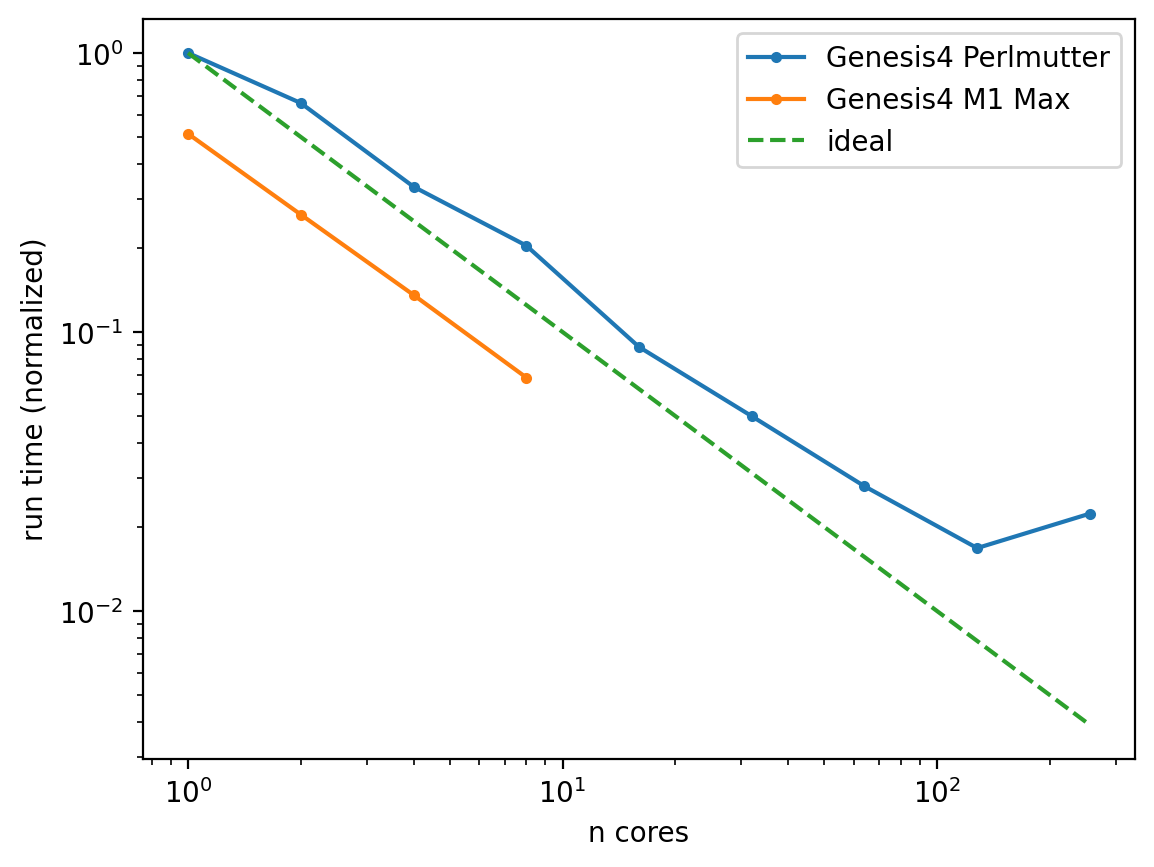

In [11]:
import numpy as np
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

# Perlmutter
nlist, tlist = (
    [256, 128, 64, 32, 16, 8, 4, 2, 1],
    [
        12.407618761062622,
        9.337806940078735,
        15.55810832977295,
        27.734387397766113,
        49.104663372039795,
        113.33639931678772,
        184.2123155593872,
        367.3742334842682,
        555.4603695869446,
    ],
)
nlist = np.array(nlist)[::-1]
tlist = np.array(tlist)[::-1]

tref = tlist[0]

# M1 Max
nlistmac, tlistmac = (
    [8, 4, 2, 1],
    [38.151074171066284, 75.41113114356995, 146.3512842655182, 285.11587405204773],
)
nlistmac = np.array(nlistmac)
tlistmac = np.array(tlistmac)


plt.plot(nlist, tlist / tref, marker=".", label="Genesis4 Perlmutter")
plt.plot(nlistmac, tlistmac / tref, marker=".", label="Genesis4 M1 Max")
plt.plot(nlist, 1 / (nlist / nlist[0]), "--", label="ideal")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("n cores")
plt.ylabel("run time (normalized)")
plt.legend()